# Day 2 Exercises (NumPy + Matplotlib)

## Part 1: Basic NumPy Operations
a) Generate an array of numbers 0-24. Reshape to a 5x5 matrix.

In [1]:
import numpy as np

mat = np.arange(25).reshape(5,5)
print(mat)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


b) Extract the diagonal of this matrix.

In [2]:
diag = np.diag(mat)
print(diag)

[ 0  6 12 18 24]


c) Multiply the matrix by an identity matrix of the same shape. Confirm that it is identical to the original.

Hint: Use `np.all` command to confirm all equal. 

In [3]:
## Construct identity matrix.
identity = np.identity(5)

## Matrix multiplication.
mat2 = mat @ identity

## Confirm all equal.
print( np.all(mat == mat2) )

True


d) Join the matrix with itself and return a new matrix with shape (2,5,5).

In [4]:
## Join matrices.
mat3 = np.array([mat, mat])
print(mat3.shape)

(2, 5, 5)


e) Compute the mean of the concatenated matrix along the first axis. Confirm its equal to the original matrix.

In [5]:
## Take mean.
mat3 = mat3.mean(axis=0)

## Confirm all equal.
print( np.all(mat == mat3) )

True


f) Return the indices of the matrix where the elements are greater than 15.

In [6]:
i,j = np.where(mat > 15)
print(i,j)

[3 3 3 3 4 4 4 4 4] [1 2 3 4 0 1 2 3 4]


g) Using `np.where`, set all elements of the matrix greater than 15 to 1, else 0.


In [7]:
## Binarize matrix (v1).
mat4 = (mat > 15).astype(int)

## Binarize matrix (v2).
mat4 = np.where(mat > 15, 1, 0)

h) Set all elements of the matrix greater than 15 to 2, less than 5 to 1, else 0.

Hint: `np.where` can be passed as an input to `np.where`.

In [8]:
## Trinarize matrix.
mat5 = np.where(mat > 15, 2, np.where(mat > 5, 1, 0))

i) Return the lower triangle of the original matrix.

In [9]:
tril = np.tril(mat)
print(tril)

[[ 0  0  0  0  0]
 [ 5  6  0  0  0]
 [10 11 12  0  0]
 [15 16 17 18  0]
 [20 21 22 23 24]]


j) Define a demean function.

In [10]:
def demean(arr):
    """De-mean array."""
    return arr - np.mean(arr)

k) Apply the demean function across each row of the matrix.

In [11]:
## Demean each row.
mat6 = np.apply_along_axis(demean, 1, mat)
print(mat6)

[[-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]]


## Part 2: Spike Detection

In [12]:
import numpy as np

## Load data.
npz = np.load('spikes.npz')
data = npz['data'] * 1e6      # Convert to uV
times = npz['times']

a) Plot the entire raw recording. Do multiple types of spikes appear to be present?

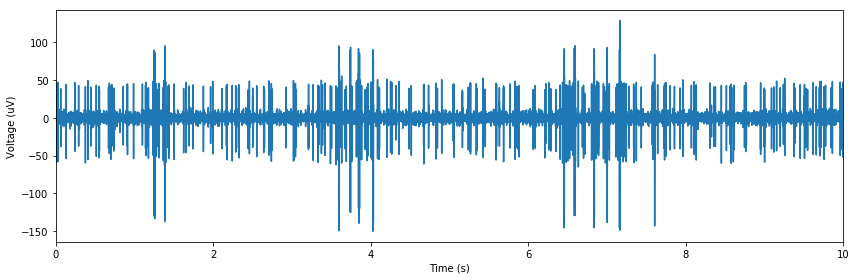

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot timeseries.
ax.plot(times, data)
ax.set(xlim=(times.min(), times.max()), xlabel='Time (s)', ylabel='Voltage (uV)')
plt.tight_layout()

b) In a recent paper, [Rey et al. (2015)](https://www.sciencedirect.com/science/article/pii/S0361923015000684) suggest a simple spike detection technique via data-driven amplitude thresholding. Specifically, they propose an amplitude threshold that is  a multiple of an estimate of the standard deviation of the noise, defined as:

$$ \text{threshold} = k \cdot \hat{\sigma}_n $$

where $k$ is a constant typically between 3-5; and $\hat{\sigma}_n$ is an estimate of the standard deviation of the noise, defined as:

$$ \hat{\sigma}_n = \frac{\text{median} \left( |X| \right)}{0.6745} $$ 

where $|X|$ is the absolute value of the raw data.

Write a function that returns the amplitude threshold as defined above. The function should accept as arguments the raw data, $X$, and the constant, $k$. 

In [14]:
def find_threshold(X, k):
    """Calculate empirical amplitude threshold.
    
    Parameters
    ----------
    X : array_like, shape (n_times,)
        Raw data trace.
    k : int
        Amplitude scalar.
        
    Returns
    -------
    sigma : float
        Amplitude threshold
        
    References
    -----
    [1] Rey, H. G., Pedreira, C., & Quiroga, R. Q. (2015). Past, present and future of 
        spike sorting techniques. Brain research bulletin, 119, 106-117.
    """
    return k * np.median( np.abs(X) ) / 0.6745

c) https://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/

In [15]:
def peak_finder(X, thresh):
    """Simple peak finding algorithm.
    
    Parameters
    ----------
    X : array_like, shape (n_times,)
        Raw data trace.
    thresh : float
        Amplitude threshold.
        
    Returns
    -------
    peak_loc : array_like, shape (n_clusters,)
        Index of peak amplitudes.
    peak_mag : array_like, shape (n_clusters,)
        Magnitude of peak amplitudes.
    """
    import numpy as np
    from scipy.ndimage import measurements
    
    ## Error-catching.
    assert X.ndim == 1
    
    ## Identify clusters.
    clusters, ix = measurements.label(X > thresh)
    
    ## Identify index of peak amplitudes. 
    peak_loc = np.concatenate(measurements.maximum_position(X, labels=clusters, index=np.arange(ix)+1))
    
    ## Identify magnitude of peak amplitudes.
    peak_mag = measurements.maximum(X, labels=clusters, index=np.arange(ix)+1)
    return peak_loc, peak_mag

d) Apply the peak detection algorithm to the raw data using a constant $k=6$. Plot a histogram of the spike amplitudes (try bins of 0-150 in increments of 5 uV). 

How many spikes are detected? How many types of spikes do there appear to be?

322 spikes detected.


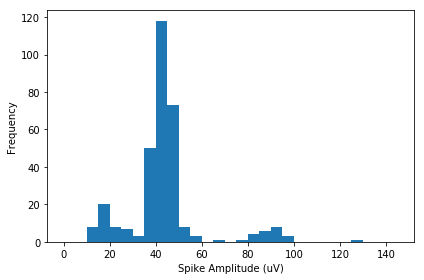

In [16]:
## Define threshold.
threshold = find_threshold(data, k=6)

## Apply peak finding.
peak_loc, peak_mag = peak_finder(data, threshold)

## Report number of spikes detected.
print(f'{peak_mag.size} spikes detected.')

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot histogram.
ax.hist(peak_mag, bins=np.arange(0,150,5))
ax.set(xlabel='Spike Amplitude (uV)', ylabel='Frequency')

plt.tight_layout()

e) Plot the first second of the data. Using a scatterplot (or any other method you can think of), indicate the peak for each detected spike.

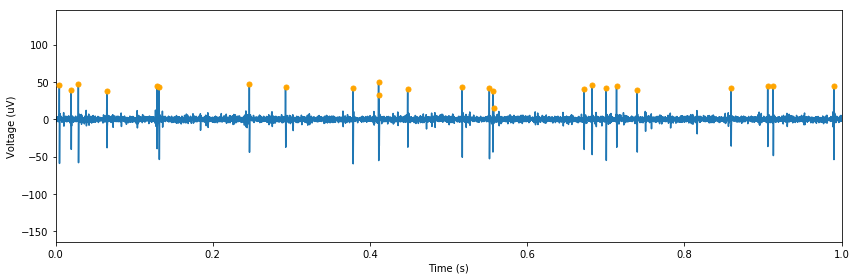

In [17]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot timeseries.
ax.plot(times, data)

## Plot peak onsets.
ax.scatter(times[peak_loc], peak_mag, color='orange', s=25, zorder=10)

ax.set(xlim=(0, 1), xlabel='Time (s)', ylabel='Voltage (uV)')
plt.tight_layout()

f) Remake the plot above, but repeating the procedure with a constant $k=2$. How trustworthy is the spike detection algorithm with this more liberal threshold?

2058 spikes detected.


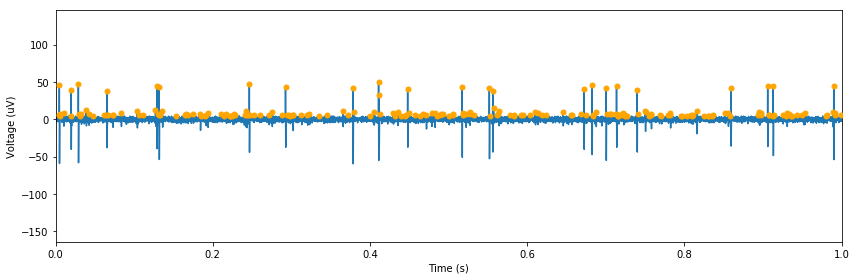

In [18]:
## Define threshold.
threshold = find_threshold(data, k=2)

## Apply peak finding.
peak_loc, peak_mag = peak_finder(data, threshold)

## Report number of spikes detected.
print(f'{peak_mag.size} spikes detected.')

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot timeseries.
ax.plot(times, data)

## Plot peak onsets.
ax.scatter(times[peak_loc], peak_mag, color='orange', s=25, zorder=10)

ax.set(xlim=(0, 1), xlabel='Time (s)', ylabel='Voltage (uV)')
plt.tight_layout()

g) Returning now to the detected spikes when $k=6$, define a set of boundaries that divides the spikes into three clusters. How many spikes are in each cluster?

In [19]:
## Define threshold.
threshold = find_threshold(data, k=6)

## Apply peak finding.
peak_loc, peak_mag = peak_finder(data, threshold)

## Define boundaries.
boundaries = [30, 70]

## Define spike labels.
labels = np.where(peak_mag > boundaries[1], 2, np.where(peak_mag > boundaries[0], 1, 0))

## Count each labels.
_, counts = np.unique(labels, return_counts=True)
print(counts)

[ 43 256  23]


h) Action potentials last roughly 1-2 milliseconds. With this in mind, extract a 3 ms window around each detected spike; that is, extract 1.5 ms of samples on either side of the detected peak. Store each epoch according to its cluster. 

Hint: The data were recorded at 10 KHz meaning there are 10 samples per millisecond. 

In [20]:
## Cluster 1.
spikes_c1 = np.zeros((counts[0], 30))
for i, loc in enumerate(peak_loc[labels==0]):
    spikes_c1[i] = data[loc-15:loc+15]
    
## Cluster 2.
spikes_c2 = np.zeros((counts[1], 30))
for i, loc in enumerate(peak_loc[labels==1]):
    spikes_c2[i] = data[loc-15:loc+15]
    
## Cluster 3.
spikes_c3 = np.zeros((counts[2], 30))
for i, loc in enumerate(peak_loc[labels==2]):
    spikes_c3[i] = data[loc-15:loc+15]

i) Plot each averaged spike waveform in a single plot. Add a legend denoting the spike cluster.

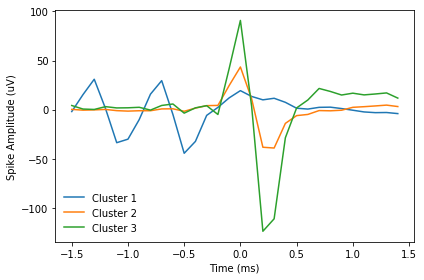

In [21]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot average waveform.
for i, spikes in enumerate([spikes_c1, spikes_c2, spikes_c3]):
    ax.plot(np.arange(-1.5,1.5,0.1), spikes.mean(axis=0), label=f'Cluster {i+1}')

## Add details.
ax.set(xlabel='Time (ms)', ylabel='Spike Amplitude (uV)')
ax.legend(loc=3, frameon=False)
    
plt.tight_layout()